# Chapter 14: Regression Diagnostics and Structure

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Diagnostics

In [2]:
np.random.seed(987654321)
x = np.random.uniform(1,100, size=500)
y = 250 + x + np.random.normal(loc=0, scale=10, size=500)
df = pd.DataFrame({'x':x, 'y':y})
reg1 = ols("y~x", data=df).fit()
reg1.params

Intercept    249.119728
x              1.042288
dtype: float64

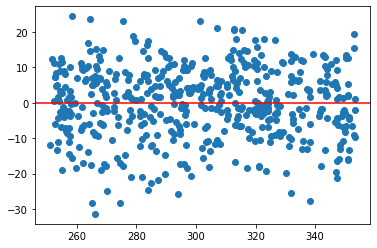

In [3]:
plt.scatter(reg1.fittedvalues, reg1.resid)
plt.axhline(0, color='red')
plt.show()

## Heteroscedasticity

In [4]:
np.random.seed(987654321)
x = np.random.uniform(1,20, size=500)
y = 100 + 2*x + x*np.random.normal(size=500)
df = pd.DataFrame({'x':x, 'y':y})
reg1 = ols("y~x", data=df).fit()
reg1.params

Intercept    98.784781
x             2.303887
dtype: float64

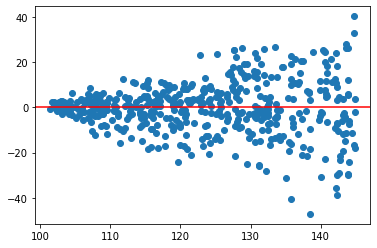

In [5]:
plt.scatter(reg1.fittedvalues, reg1.resid)
plt.axhline(0, color='red')
plt.show()

***logistic regression***

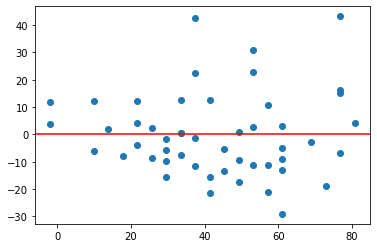

0.6510793807582509

In [6]:
cars = pd.read_csv("../data/cars.csv")
reg2 = ols("dist ~ speed", data=cars).fit()
plt.scatter(reg2.fittedvalues, reg2.resid)
plt.axhline(0, color='red')
plt.show()

reg2.rsquared

In [7]:
reg2.params

Intercept   -17.579095
speed         3.932409
dtype: float64

***Bresuch-Pagan test***

In [8]:
from statsmodels.compat import lzip
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']

In [9]:
test1 = sm.stats.diagnostic.het_breuschpagan(reg1.resid, reg1.model.exog)
lzip(names, test1)

[('Lagrange multiplier statistic', 94.5833482166779),
 ('p-value', 2.3498677853334443e-22),
 ('f-value', 116.18296191020761),
 ('f p-value', 1.7179132159423896e-24)]

In [10]:
test2 = sm.stats.diagnostic.het_breuschpagan(reg2.resid, reg2.model.exog)
lzip(names, test2)

[('Lagrange multiplier statistic', 3.214879927174641),
 ('p-value', 0.07297154505407806),
 ('f-value', 3.2983614504820826),
 ('f p-value', 0.07559716486053959)]

***Box Cox transformation***

In [11]:
fitted_data1, fitted_lambda1 = scipy.stats.boxcox(y)
fitted_lambda1

-1.5741315427789888

In [12]:
fitted_data2, fitted_lambda2 = scipy.stats.boxcox(cars.dist)
fitted_lambda2

0.4950761909055122

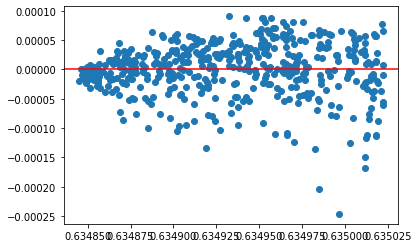

In [13]:
y1 = fitted_data1
df1 = pd.DataFrame({'x':x, 'y1':y1})
reg3 = ols("y1~x", data=df1).fit()
plt.scatter(reg3.fittedvalues, reg3.resid)
plt.axhline(0, color='red')
plt.show()

In [14]:
test3 = sm.stats.diagnostic.het_breuschpagan(reg3.resid, reg3.model.exog)
lzip(names, test3)

[('Lagrange multiplier statistic', 30.077635108296253),
 ('p-value', 4.1509084365023434e-08),
 ('f-value', 31.874759328348706),
 ('f p-value', 2.7656251542738505e-08)]

In [15]:
reg3.rsquared

0.5670580845119884

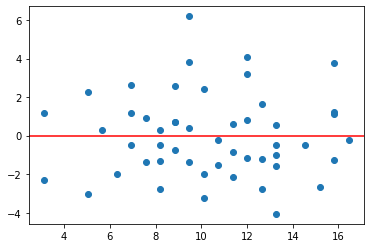

In [16]:
dist1 = fitted_data2
cars1 = pd.DataFrame({'speed':cars['speed'], 'dist1':dist1})
reg4 = ols("dist1 ~ speed", data=cars1).fit()
plt.scatter(reg4.fittedvalues, reg4.resid)
plt.axhline(0, color='red')
plt.show()

In [17]:
test4 = sm.stats.diagnostic.het_breuschpagan(reg4.resid, reg4.model.exog)
lzip(names, test4)

[('Lagrange multiplier statistic', 0.005927257689752885),
 ('p-value', 0.9386325459422038),
 ('f-value', 0.005690842003903435),
 ('f p-value', 0.9401800262578285)]

In [18]:
reg4.rsquared

0.7096882570316119

## Extreme Values

In [19]:
np.random.seed(987654321)
x = np.random.uniform(low=1, high=100, size=(500,))
y = 250 + x + np.random.normal(loc=0,scale=10,size=(500,))
df = pd.DataFrame({'x':x, 'y':y})
reg1 = ols("y~x", data=df).fit()
reg1.params

Intercept    249.119728
x              1.042288
dtype: float64

In [20]:
x[499]=860
df = pd.DataFrame({'x':x, 'y':y})
reg1 = ols("y~x", data=df).fit()
reg1.params

Intercept    278.441160
x              0.439657
dtype: float64

***Cook's distance***

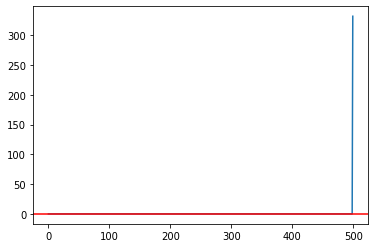

In [21]:
cd = reg1.get_influence().cooks_distance
cutoff = 4/500
plt.plot(cd[0])
plt.axhline(cutoff, color='red')
plt.show()

In [22]:
reg2 = ols("y~x", data=df.drop(df.index[[159, 309, 499]])).fit()
reg2.params

Intercept    249.157346
x              1.041671
dtype: float64

In [23]:
admit = pd.read_csv("../data/admit.csv")
admit.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [24]:
breg1=sm.formula.glm("admit~gre+gpa+rank", data=admit, family=sm.families.Binomial()).fit()
np.round(breg1.params, 3)

Intercept   -3.450
gre          0.002
gpa          0.777
rank        -0.560
dtype: float64

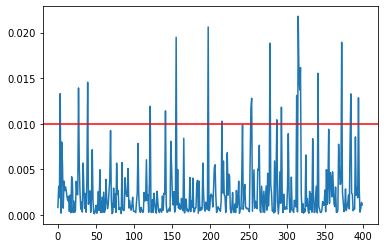

In [25]:
z = breg1.get_influence().cooks_distance
cutoff = 4/len(admit)
plt.plot(z[0])
plt.axhline(cutoff, color='red')
plt.show()

In [26]:
breg1=sm.formula.glm("admit~gre+gpa+rank", data=admit.drop(admit.index[[156, 198, 316]]), family=sm.families.Binomial()).fit()
breg1.params

Intercept   -3.598649
gre          0.002517
gpa          0.775080
rank        -0.552710
dtype: float64

<AxesSubplot:xlabel='gre'>

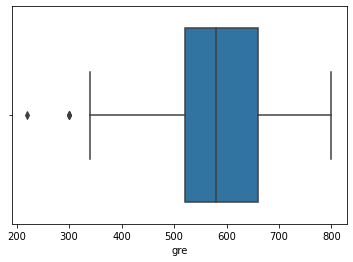

In [27]:
import seaborn as sns
sns.boxplot(x=admit['gre'])

## Multicollinearity

In [28]:
np.random.seed(987654321)
x1 = np.random.uniform(low=1, high=10, size=(500,))
a = 0.7
x2 = a * x1 + (1-a)*np.random.uniform(low=1, high=10, size=(500,))
np.corrcoef(x1,x2)

array([[1.        , 0.92128094],
       [0.92128094, 1.        ]])

In [29]:
y = 2*x1 + x2 + np.random.normal(loc=0,scale=10,size=(500,))
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
reg1 = ols("y~x1+x2", data=df).fit()
round(reg1.params,3)

Intercept   -2.480
x1           1.848
x2           1.671
dtype: float64

***Variance Inflation Factor (VIF)***

In [30]:
reg2 = ols("x1~x2", data=df).fit()
r2_1 = reg2.rsquared
r2_1

0.8487585674194995

In [31]:
vif_x1 = 1/(1-r2_1)
vif_x1

6.611944775567602

In [32]:
round(admit.corr(),3)

,admit,gre,gpa,rank
admit,1.000,0.184,0.178,-0.243
gre,0.184,1.000,0.384,-0.123
gpa,0.178,0.384,1.000,-0.057
rank,-0.243,-0.123,-0.057,1.000


N/A

## Regression Structure

In [33]:
np.random.seed(987654321)
x = np.random.uniform(low=1, high=20, size=(500,))
y = 100 + 2*x + 0.5*(x**2) + np.random.uniform(size=(500,))
df = pd.DataFrame({'x':x, 'y':y})
reg1 = ols("y~x", data=df).fit()
reg1.rsquared

0.9611678923423614

In [34]:
reg1.params

Intercept    60.724055
x            12.476621
dtype: float64

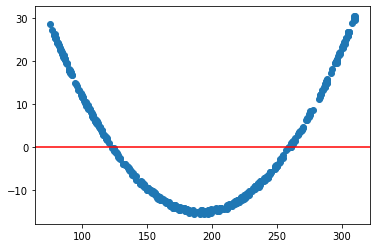

In [35]:
plt.scatter(reg1.fittedvalues, reg1.resid)
plt.axhline(0, color='red')
plt.show()

## Power Transformation

***Box-Tidwell transformation***

N/A

In [36]:
MASchools = pd.read_csv("../data/MASchools.csv")
df = MASchools.iloc[:,[12,6,7,8,10,14]]
df1 = df.dropna()
reg1 = ols("score4~exptot+scratio+special+stratio+salary", data=df1).fit()
reg1.rsquared

0.2755062790920212

In [37]:
test1 = sm.stats.diagnostic.het_breuschpagan(reg1.resid, reg1.model.exog)
lzip(names, test1)

[('Lagrange multiplier statistic', 22.49849723455402),
 ('p-value', 0.0004208229288997204),
 ('f-value', 4.953752025177818),
 ('f p-value', 0.00028337744339731124)]

N/A

In [38]:
df1['stratio_pow_4'] = np.power(df['stratio'], 4)
df1['salary_pow_6'] = np.power(df['salary'], 6)
reg2 = ols("score4~exptot+scratio+special+stratio+salary+stratio_pow_4+salary_pow_6", data=df1).fit()
reg2.rsquared

<ipython-input-38-9cf6a6fc8428>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['stratio_pow_4'] = np.power(df['stratio'], 4)
<ipython-input-38-9cf6a6fc8428>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['salary_pow_6'] = np.power(df['salary'], 6)


0.33524106191662273

In [39]:
test2 = sm.stats.diagnostic.het_breuschpagan(reg2.resid, reg2.model.exog)
lzip(names, test2)

[('Lagrange multiplier statistic', 16.052973982783417),
 ('p-value', 0.02463676496571995),
 ('f-value', 2.4019496258843227),
 ('f p-value', 0.022600971587313713)]

In [40]:
breg1 = sm.formula.glm("admit~gre+gpa+rank", data=admit, family=sm.families.Binomial()).fit()
logodds = breg1.predict(exog=admit)

N/A

## Interaction terms

In [41]:
np.random.seed(987654321)
x1 = np.random.uniform(low=1, high=20, size=(500,))
x2 = np.random.uniform(low=1, high=20, size=(500,))
y = x1 + 4*x2 + 0.5*x1*x2 + np.random.uniform(size=(500,))
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
reg1 = ols("y~x1+x2", data=df).fit()
reg1.params

Intercept   -58.605951
x1            6.334375
x2            9.435495
dtype: float64

N/A

In [42]:
reg2 = ols("score4~exptot+scratio+special+stratio+salary+stratio_pow_4+salary_pow_6", data=df1).fit()


In [43]:
breg1 = sm.formula.glm("admit~gre+gpa+rank+gre:gpa", data=admit, family=sm.families.Binomial()).fit()


## Variable Selection

***Stepwise Regression***

In [44]:
np.random.seed(987654321)
x1 = np.random.uniform(low=1, high=10, size=(500,))
x2 = np.random.uniform(low=1, high=10, size=(500,))
y = 2*x1 + x2 + np.random.normal(loc=0,scale=10,size=(500,))
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
df['x1_pow_2'] = np.power(df['x1'], 2)
df['x2_pow_3'] = np.power(df['x2'], 3)
reg1 = ols("y~x1+x2+x1:x2+x1_pow_2+x2_pow_3", data=df)


In [45]:
reg1 = ols("score4~exptot+scratio+special+stratio+salary+stratio_pow_4+salary_pow_6+ \
            exptot:scratio+special:stratio_pow_4+scratio:special+exptot:stratio_pow_4+ \
            exptot:stratio+special:stratio+scratio:salary_pow_6", data=df1).fit()


***Subsets Regression***

N/A